# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 3

In [ ]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as functional
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

In [118]:
from stepbystep.v0 import StepByStep
from plots.chapter3 import figure1, figure2, figure3, figure4, figure7, figure9, figure10, figure17, figure19, figure20, figure21
from plots.chapter3 import one_dimension, two_dimensions, eval_curves, eval_curves_from_probs

# A Simple Classification Problem

## Data Generation

In [2]:
X, y = make_moons(n_samples=100, noise=.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [3]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

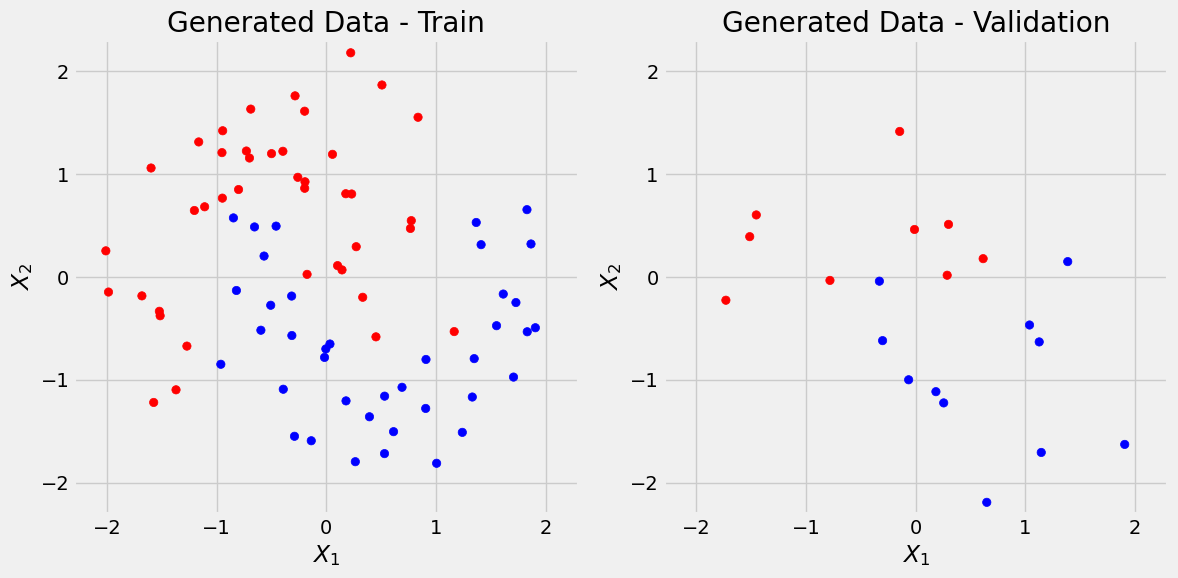

In [5]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

In [4]:
torch.manual_seed(13)

# Build tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Build datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Build data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Model

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

$$
\Large
y = 
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

### Logits

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

### Probabilities

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### Odds Ratio

$$
\Large \text{odds ratio (p)} = \frac{p}{q} = \frac{p}{1-p}
$$

In [5]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [7]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

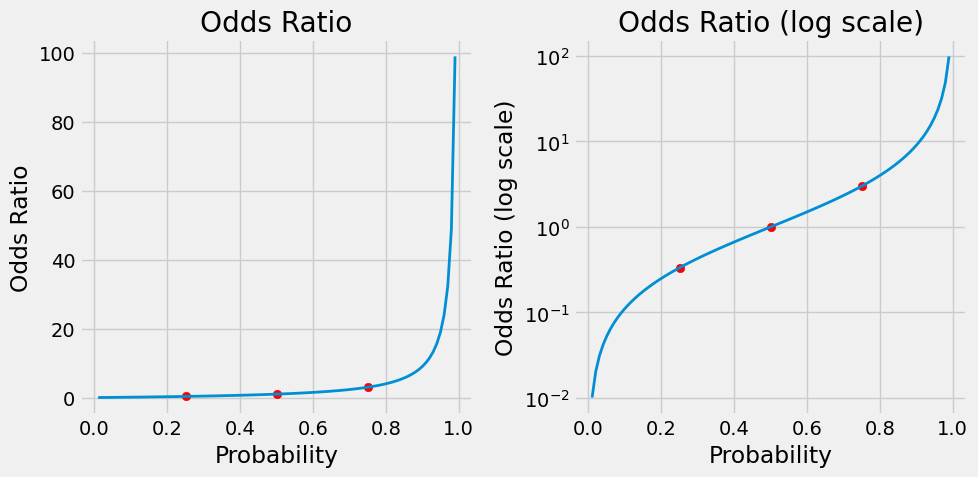

In [8]:
fig = figure2(p)

### Log Odds Ratio

$$
\Large \text{log odds ratio (p)} = \text{log}\left(\frac{p}{1-p}\right)
$$

In [6]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

In [9]:
p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(np.float64(1.0986122886681098), np.float64(-1.0986122886681098))

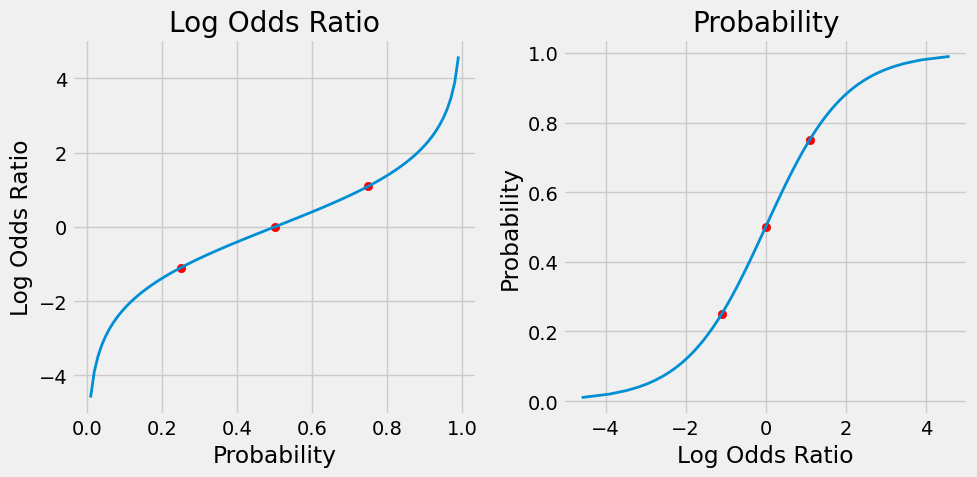

In [12]:
fig = figure3(p)

### From Logits to Probabilities

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large p = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(np.float64(0.75), np.float64(0.25))

### Sigmoid

In [14]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

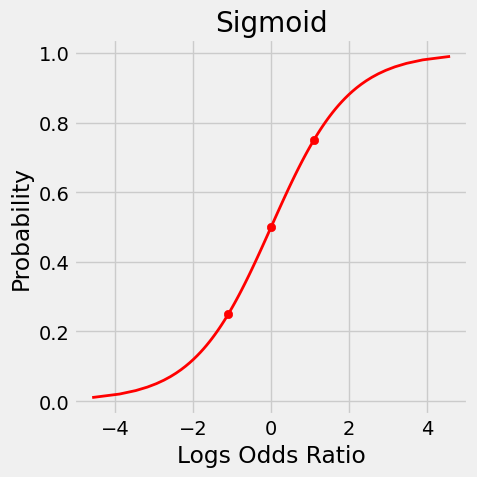

In [16]:
fig = figure4(p)

### Logistic Regression

$$
\Large P(y=1) = \sigma(z) = \sigma(b + w_1x_1 + w_2x_2)
$$

![](images/logistic_model.png)

In [17]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict({'linear.weight': tensor([[0.5406, 0.5869]]), 'linear.bias': tensor([-0.1657])})


### A Note on Notation

$$
\Large
W = 
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}
}
$$

$$
\Large
\begin{aligned}
z& = W^T X = 
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^T & -
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= 
\underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
\\
& = b + w_1 x_1 + w_2 x_2
\end{aligned}
$$

## Loss

$$
\Large y_i = 1 \Rightarrow error_i = log(P(y_i = 1))
$$

$$
\Large P(y_i = 0) = 1 - P(y_i = 1)
$$

$$
\Large y_i = 0 \Rightarrow error_i = log(1 - P(y_i = 1))
$$

$$
\Large
BCE(y) = - \frac{1}{(N_{pos} + N_{neg})}
\Bigg[
    \sum_{i = 1}^{N_{pos}} log(P(y_i = 1)) + \sum_{i = 1}^{N_{neg}} log(1 - P(y_i = 1))
\Bigg]
$$

In [22]:
dummy_labels = torch.tensor([1., .0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
pos_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(pos_pred).sum()

# Negative class (labels == 0)
neg_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - neg_pred).sum()

# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

$$
\Large BCE(y) = - \frac{1}{N} \sum_{i=1}^{N}
\Bigg[
    y_i log(P(y_i = 1)) + (1 - y_i)log(1 - P(y_i = 1))
\Bigg]
$$

In [23]:
summation = torch.sum(dummy_labels * torch.log(dummy_predictions) + (1 - dummy_labels) * torch.log(1 - dummy_predictions))
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

In [24]:
loss_fn = nn.BCELoss(reduction='mean')
loss_fn

BCELoss()

In [25]:
loss = loss_fn(dummy_predictions, dummy_labels)
loss

tensor(0.1643)

### BCEWithLogitsLoss

In [26]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')
loss_fn_logits

BCEWithLogitsLoss()

In [27]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [28]:
loss = loss_fn_logits(dummy_logits, dummy_labels)

loss

tensor(0.1643)

### Imbalanced Dataset

In [29]:
dummy_imb_labels = torch.tensor([1., .0, .0, .0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

In [31]:
n_neg = (dummy_imb_labels == 0).sum()
n_pos = (dummy_imb_labels == 1).sum()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [32]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)

loss

tensor(0.2464)

In [33]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)
loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [8]:
lr = .1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [14]:
epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(epochs)

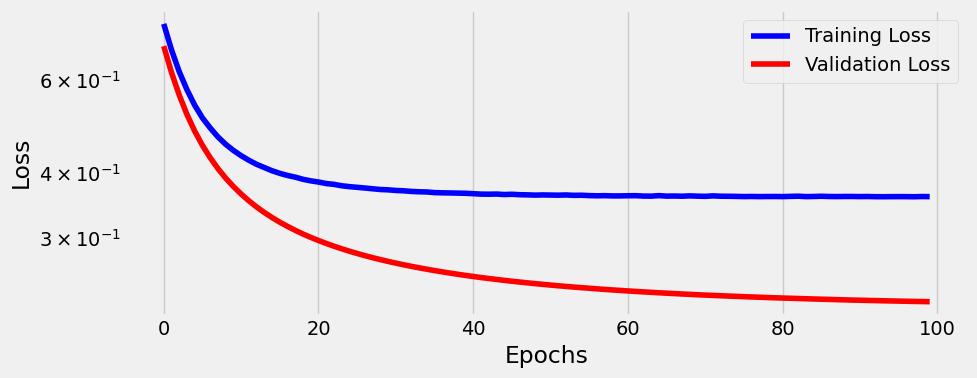

In [15]:
fig = sbs.plot_losses()

In [16]:
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[ 1.1806, -1.8693]], device='cuda:0'), 'linear.bias': tensor([-0.0591], device='cuda:0')})


$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1 x_1 & + & w_2 x_2
\\
z & = & -0.0591 & + & 1.1806 x_1 & - & 1.1806 x_2
\end{array}
$$

#### Making Predictions (Logits)

In [18]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345594],
       [ 2.9444456 ],
       [ 3.693318  ],
       [-1.2334074 ]], dtype=float32)

#### Making Predictions (Probabilities)

In [19]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892],
       [0.9500003],
       [0.9757152],
       [0.2255856]], dtype=float32)

#### Making Predictions (Classes)

$$
\Large y = 
\begin{cases}
1,\ \text{if }P(y=1) \ge 0.5
\\
0,\ \text{if }P(y=1) < 0.5
\end{cases}
$$

$$
\Large y = 
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y = 
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [20]:
classes = (predictions >= 0).astype(int)

classes

array([[1],
       [1],
       [1],
       [0]])

## Decision Boundary

$$
\Large
\begin{array}{ccccccccc}
z & = & 0 & = & b & + & w_1 x_1 & + & w_2 x_2
\\
& & -w_2 x_2 & = & b & + & w_1 x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - & \frac{w_1}{w_2} x_1 & &
\end{array}
$$

$$
\Large
\begin{array}{ccccc}
x_2 & = & -\frac{-0.0591}{-1.8693} & - & \frac{1.1806}{-1.8693} x_1
\\
\\
x_2 & = & -0.0316 & + & 0.6316 x_1
\end{array}
$$

In [24]:
x_min, x_max = -2.25, 2.25
y_min, y_max = -2.25, 2.25

xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

In [25]:
xx, yy

(array([[-2.25, -2.23, -2.21, ...,  2.19,  2.21,  2.23],
        [-2.25, -2.23, -2.21, ...,  2.19,  2.21,  2.23],
        [-2.25, -2.23, -2.21, ...,  2.19,  2.21,  2.23],
        ...,
        [-2.25, -2.23, -2.21, ...,  2.19,  2.21,  2.23],
        [-2.25, -2.23, -2.21, ...,  2.19,  2.21,  2.23],
        [-2.25, -2.23, -2.21, ...,  2.19,  2.21,  2.23]]),
 array([[-2.25, -2.25, -2.25, ..., -2.25, -2.25, -2.25],
        [-2.23, -2.23, -2.23, ..., -2.23, -2.23, -2.23],
        [-2.21, -2.21, -2.21, ..., -2.21, -2.21, -2.21],
        ...,
        [ 2.19,  2.19,  2.19, ...,  2.19,  2.19,  2.19],
        [ 2.21,  2.21,  2.21, ...,  2.21,  2.21,  2.21],
        [ 2.23,  2.23,  2.23, ...,  2.23,  2.23,  2.23]]))

In [26]:
xx.ravel(), yy.ravel()

(array([-2.25, -2.23, -2.21, ...,  2.19,  2.21,  2.23]),
 array([-2.25, -2.25, -2.25, ...,  2.23,  2.23,  2.23]))

In [27]:
np.c_[xx.ravel(), yy.ravel()]

array([[-2.25, -2.25],
       [-2.23, -2.25],
       [-2.21, -2.25],
       ...,
       [ 2.19,  2.23],
       [ 2.21,  2.23],
       [ 2.23,  2.23]])

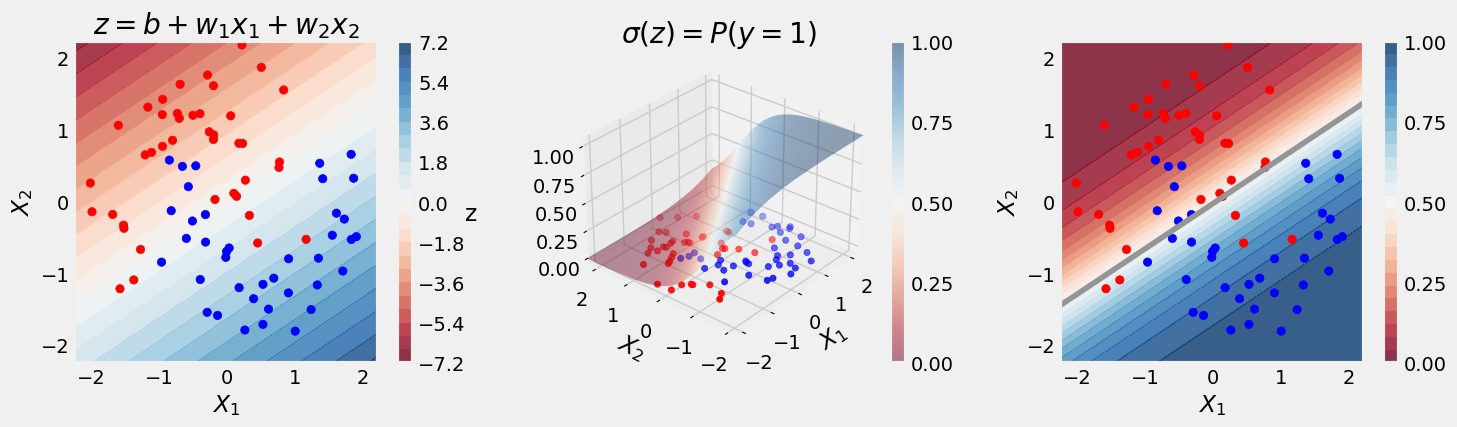

In [32]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

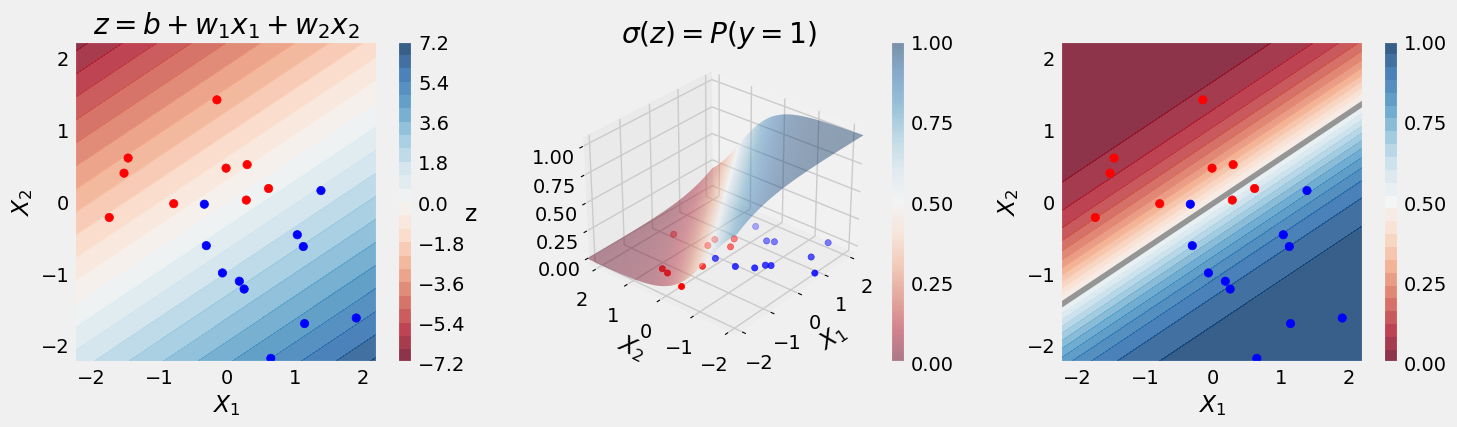

In [33]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

### Are my data points separable?

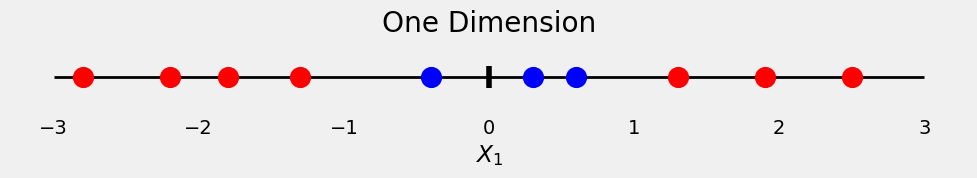

In [38]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

$$
\Large X_2 = f(X_1) = X_1^2
$$

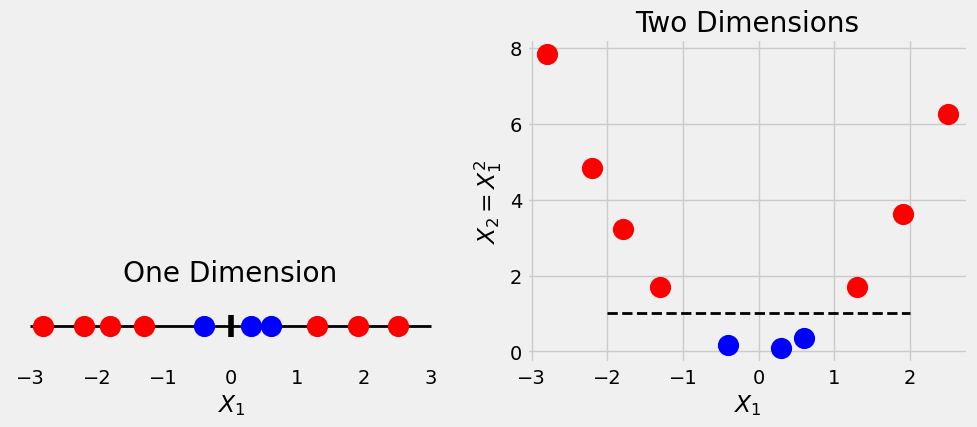

In [50]:
fig = two_dimensions(x, y)

In [ ]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

## Classification Threshold

In [52]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = .5

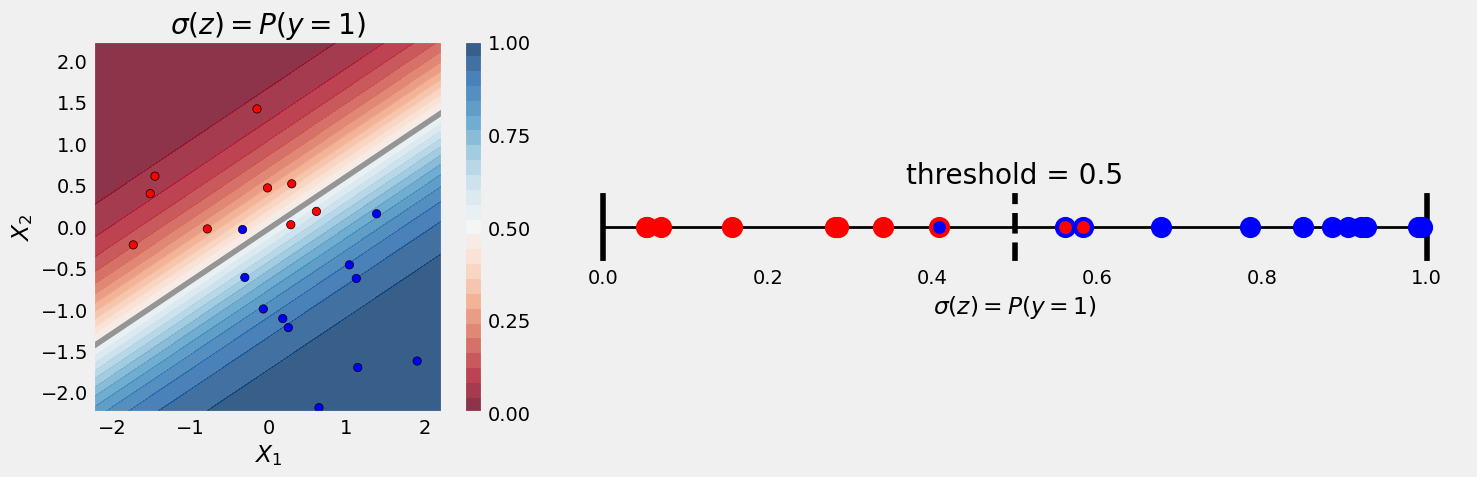

In [68]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

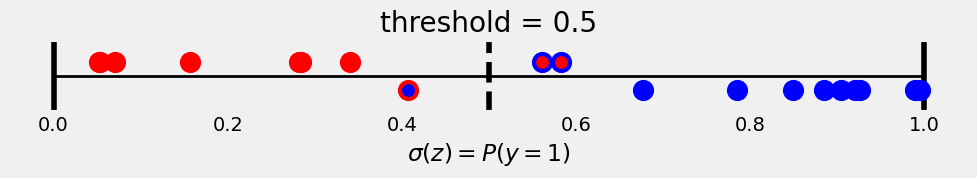

In [72]:
fig = figure10(y_val, probabilities_val, threshold, shift=0.04)

### Confusion Matrix

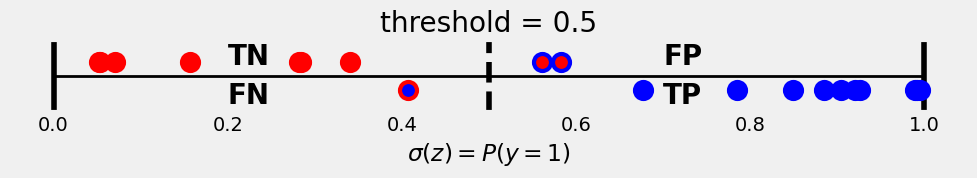

In [73]:
fig = figure10(y_val, probabilities_val, threshold, shift=0.04, annot=True)

In [74]:
cm_threshold50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_threshold50

# array([[ 7,  2],
#        [ 1, 10]])

array([[ 7,  2],
       [ 1, 10]])

#### True and False Positives and Negatives

In [77]:
def split_cm(cm):
    # Actual negatives go in the top row, above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    return tn, fp, fn, tp

### Metrics

### True and False Positive Rates

$$
\Large TPR = \frac{TP}{TP + FN} \ \ \ FPR = \frac{FP}{FP + TN}
$$

In [75]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

In [78]:
tpr_fpr(cm_threshold50)

(np.float64(0.9090909090909091), np.float64(0.2222222222222222))

### Precision and Recall

$$
\Large Recall = \frac{TP}{TP + FN} \ \ \ Precision = \frac{TP}{TP + FP}
$$

In [79]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

In [80]:
precision_recall(cm_threshold50)

(np.float64(0.8333333333333334), np.float64(0.9090909090909091))

### Accuracy

$$
\Large Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

## Trade-offs and Curves

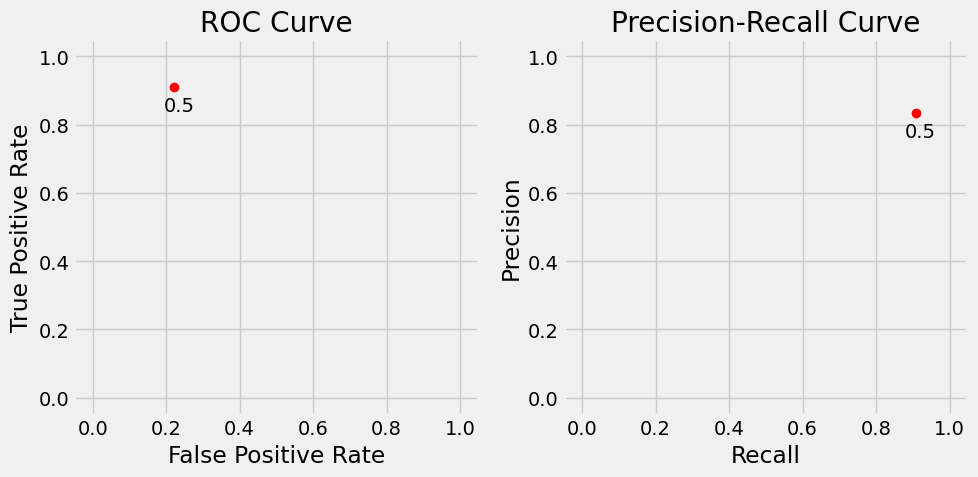

In [91]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

### Low Threshold

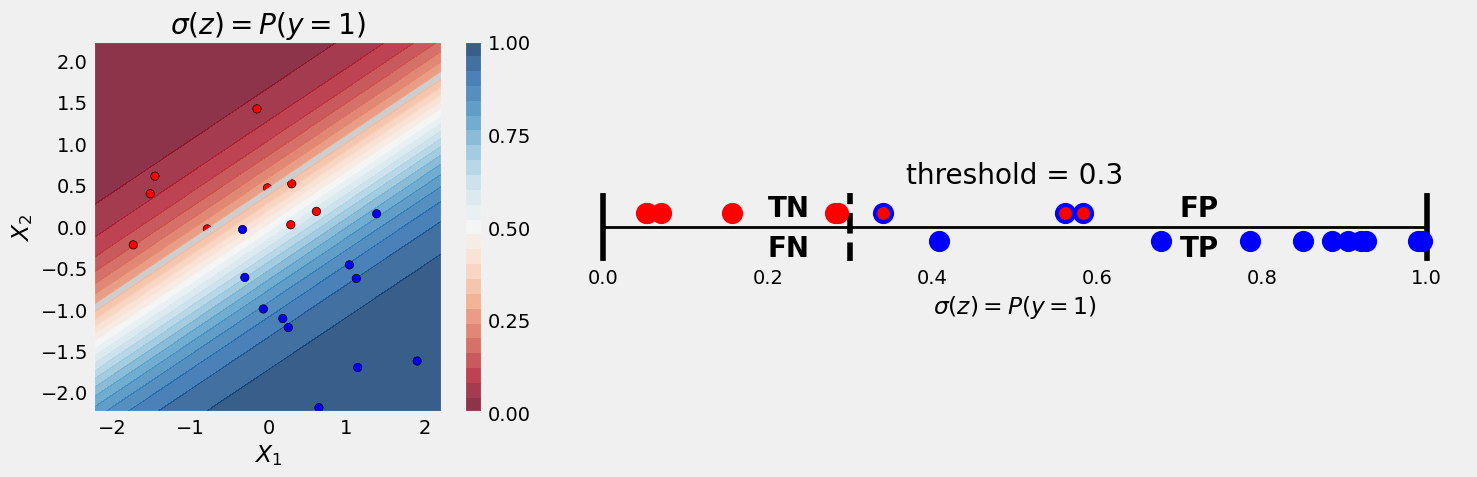

In [92]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

In [94]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

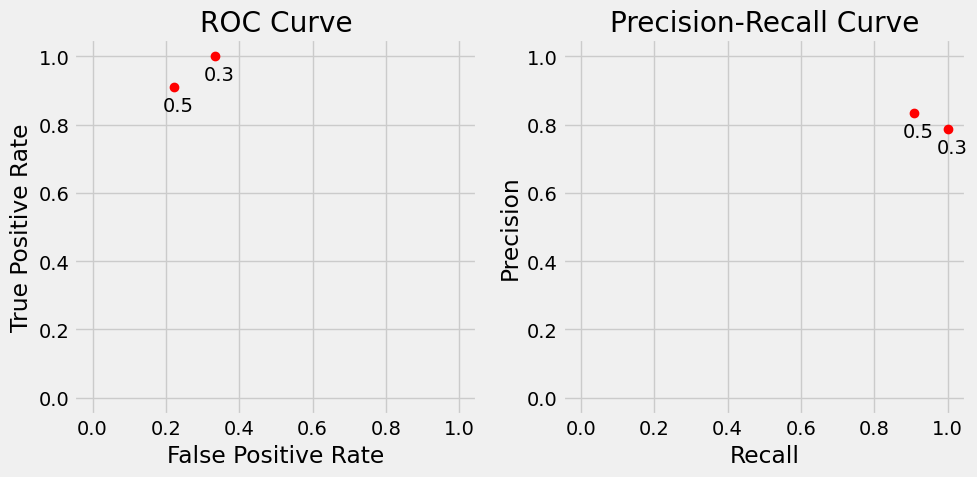

In [95]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold

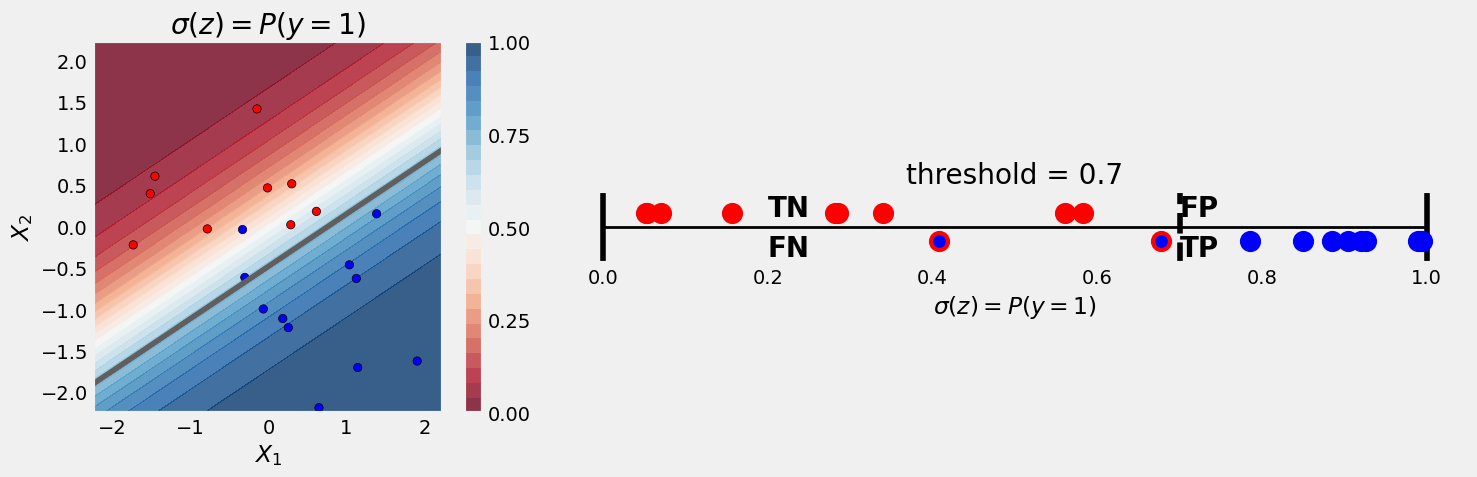

In [96]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [97]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

# array([[9, 0],
#        [2, 9]])

array([[9, 0],
       [2, 9]])

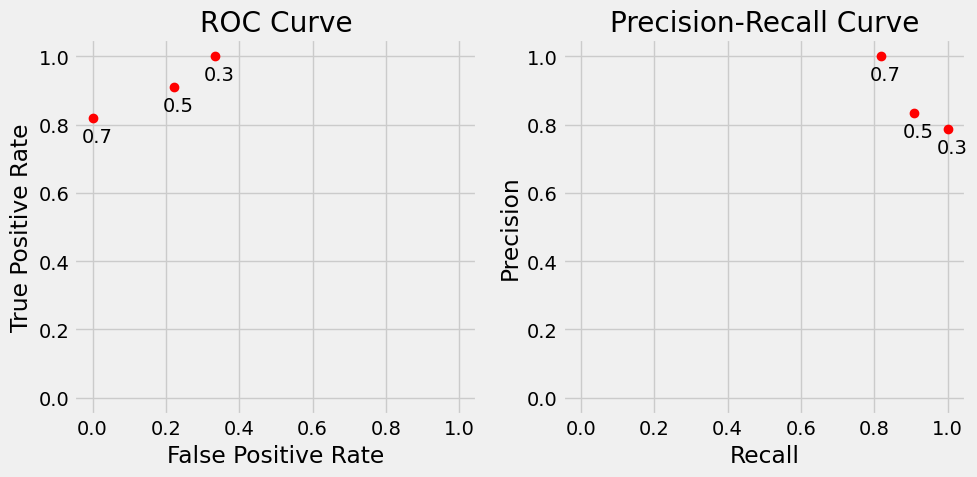

In [98]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

In [99]:
threshs = np.linspace(0, 1, 11)

/zdata/Github/pytorchsbs/plots/chapter3.py:342: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


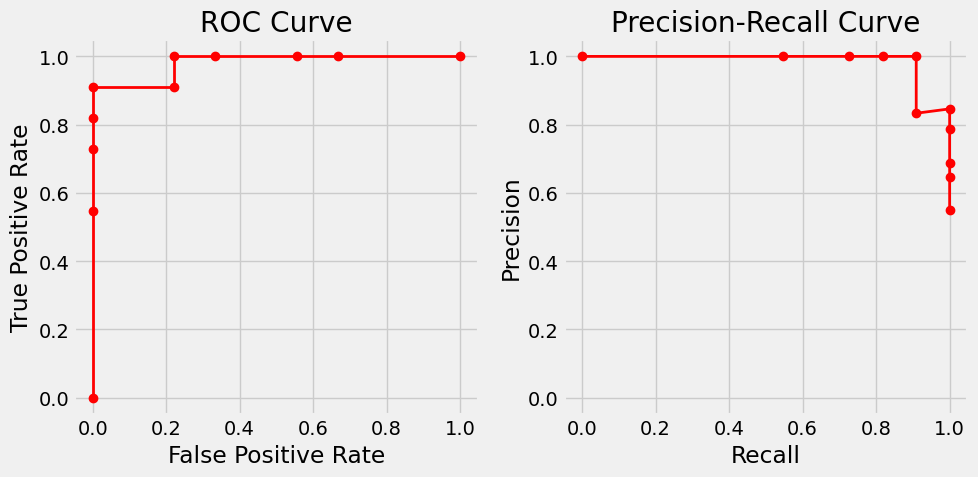

In [101]:
fig = figure17(y_val, probabilities_val, threshs)

In [105]:
fprs, tprs, thresholds1 = roc_curve(y_val, probabilities_val)
precs, recs, thresholds2 = precision_recall_curve(y_val, probabilities_val)

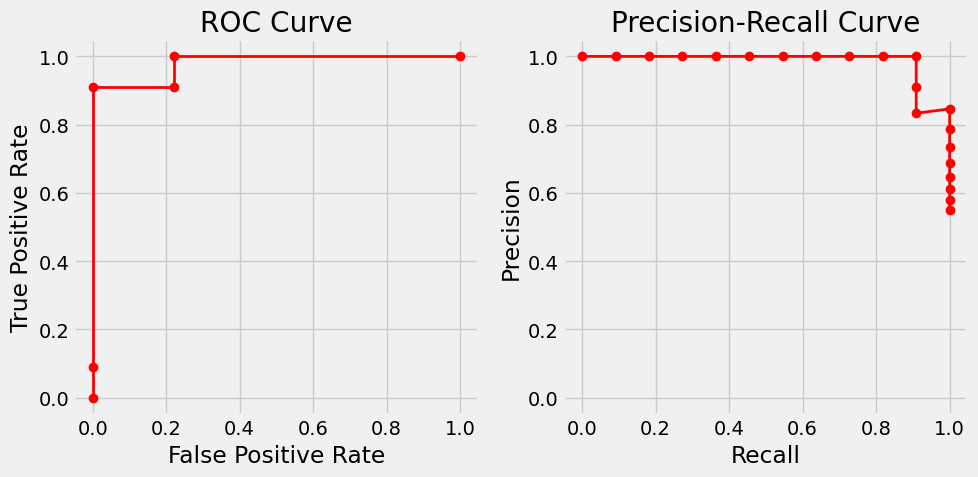

In [110]:
fig = eval_curves(fprs, tprs, recs, precs, thresholds1, thresholds2, line=True)

### The Precision Quirk

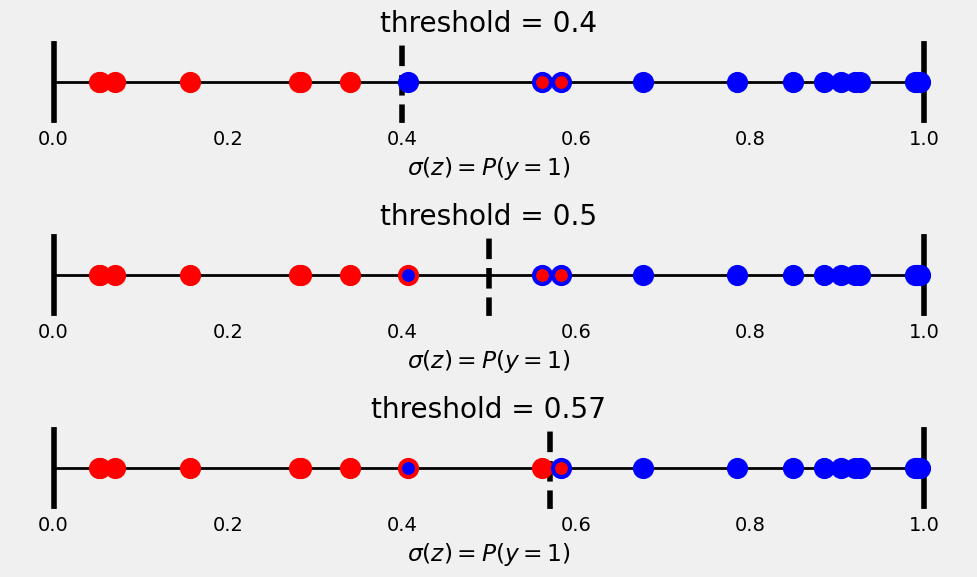

In [112]:
fig = figure19(y_val, probabilities_val)

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

### Best and Worst Curves

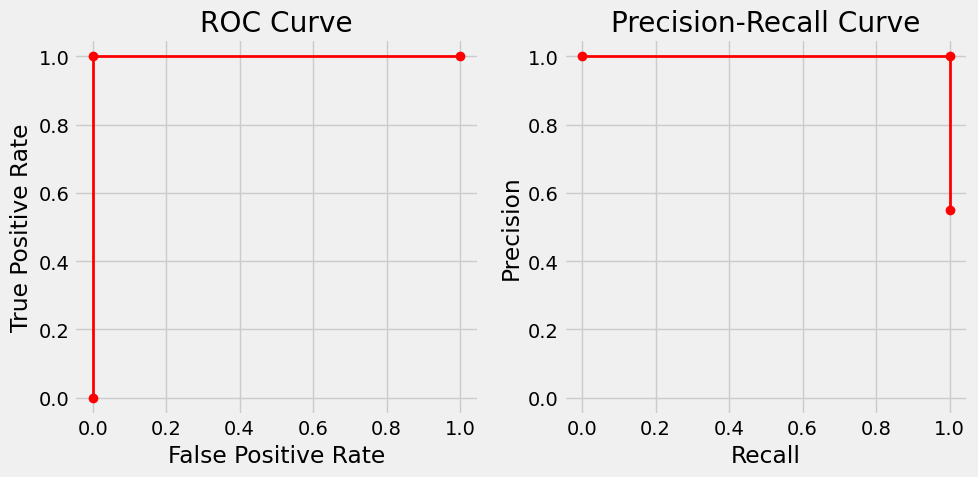

In [114]:
# Best
fig = figure20(y_val)

In [116]:
rng = np.random.default_rng(39)
random_probs = rng.standard_normal(y_val.shape)

fprs_random, tprs_random, thresholds1_random = roc_curve(y_val, random_probs)
precs_random, recs_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

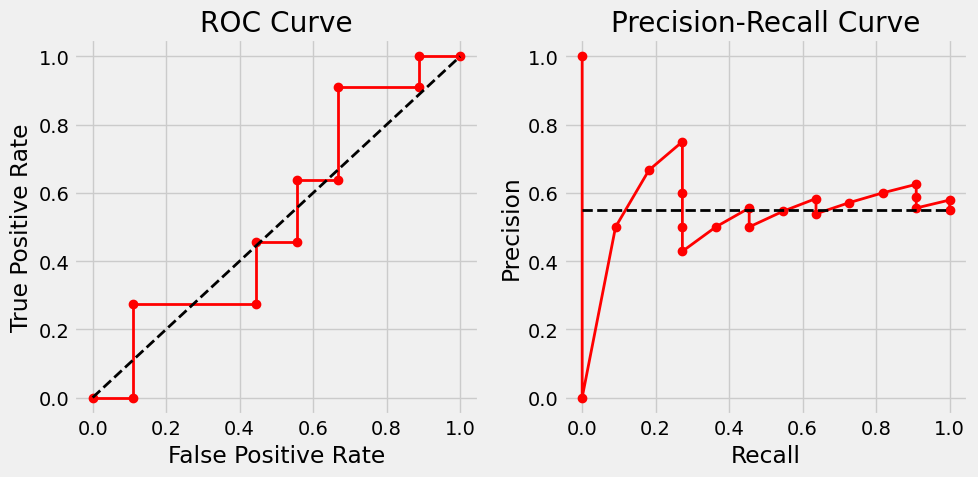

In [119]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

In [120]:
# Area under the curves of our model
auroc = auc(fprs, tprs)
aupr = auc(recs, precs)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [121]:
# Area under the curves of the random model
auroc_random = auc(fprs_random, tprs_random)
aupr_random = auc(recs_random, precs_random)
print(auroc_random, aupr_random)

0.5252525252525253 0.540114743045365


## Putting It All Together

In [ ]:
torch.manual_seed(13)

# Build tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Build datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Build data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [ ]:
lr = .1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(epochs)

In [ ]:
print(model.state_dict())

In [ ]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50